### Crop individual 2D images of (322,210) to the standard CropNet dimension (284,120) using CropNet
### Crop labels in the same way, but with nearest neighbor interpolation and no noise padding

In [7]:
ENV["CUDA_VISIBLE_DEVICES"] = "3"

"3"

In [10]:
using UNet2D
using SegmentationTools
using LinearAlgebra
using Interpolations
using Images
using Random
using HDF5
using PyPlot
using Statistics
using BehaviorDataNIR

In [11]:
### new function
function crop_mask(mask, image, crop_params, theta; dtype=UInt16)
    rotated_image = parent(imrotate(image, -theta, 0.0, Constant()))
    if dtype <: Integer
        rotated_image = round.(rotated_image)
    end
    rotated_image = dtype.(rotated_image)
    cropped_image = actually_crop(rotated_image, crop_params)

    return cropped_image
end

crop_mask (generic function with 1 method)

In [12]:
### a myriad of thomas' existing functions
function smooth_blob(bitmatrix::BitMatrix, kernel_radius::Int = 8)
    # Create a circular structuring element
    selem = create_disk(kernel_radius)

    # Apply morphological closing
    closed = closing(bitmatrix, selem)

    return closed
end

function create_disk(radius::Int)
    center = radius + 1
    strel = falses(2*radius + 1, 2*radius + 1)
    for x in 1:size(strel, 1)
        for y in 1:size(strel, 2)
            if sqrt((center - x)^2 + (center - y)^2) <= radius
                strel[x, y] = true
            end
        end
    end
    return strel
end

function remove_bisections(img, mask_old, brightest_cutoff_pct)
    mask = copy(mask_old)
    bright_pixels = get_bright_pixels(img, brightest_cutoff_pct)
    while expand_into_bright_pixels(img, mask, bright_pixels)
        continue
    end
    return mask
end

function dilate_mask(mask, radius)
    # Create a structuring element for dilation
    selem = trues(2*radius + 1, 2*radius + 1)
    return dilate(mask, selem)
end

function remove_small_blobs(mask::BitMatrix)
    # Label connected components
    labels = label_components(mask)

    # Count pixels in each blob
    blob_counts = Dict{Int, Int}()
    for val in labels
        blob_counts[val] = get(blob_counts, val, 0) + 1
    end

    # If no blobs (only bg) just return
    if length(blob_counts) == 1
        return mask
    else
        # Remove 0 label (background) from the counts
        delete!(blob_counts, 0)

        # Find the largest blob label
        largest_blob_label = argmax(blob_counts)[1]

        # Create a new bitmatrix where only the largest blob is retained
        cleaned_mask = labels .== largest_blob_label

        return cleaned_mask
    end
end

function get_bright_pixels(img, percentage)
    threshold = quantile(img[:], 1 - percentage)
    return img .> threshold
end

function expand_into_bright_pixels(img, mask, bright_pixels)
    boundary = get_boundary(mask)
    changes = false

    for i in 2:size(img, 1)-1
        for j in 2:size(img, 2)-1
            if boundary[i, j]
                for di in -1:1
                    for dj in -1:1
                        if bright_pixels[i+di, j+dj] && !mask[i+di, j+dj]
                            mask[i+di, j+dj] = true
                            changes = true
                        end
                    end
                end
            end
        end
    end
    return changes
end

function get_boundary(mask)
    # Use the Laplacian filter to detect edges
    filter = [-1 -1 -1; -1 8 -1; -1 -1 -1]
    boundary_img = imfilter(Float64.(mask), filter)
    return boundary_img .> 0
end

function get_crop_rotate_param(mask, vol, crop_size; prev_theta=0.0)
    # Try minimum bounding box first
    crop_params, theta, rotated_h, rotated_w = minimum_rotated_bbox(mask, ref_angle=prev_theta)
    bbox_crop_h = crop_params[2]-crop_params[1] +1
    bbox_crop_w = crop_params[4]-crop_params[3] +1
    pca_used = false
    if (bbox_crop_h <= crop_size[1] && bbox_crop_w <= crop_size[2])
        diff_h = crop_size[1] - bbox_crop_h
        diff_w = crop_size[2] - bbox_crop_w
        crop_params[1] -= floor(Int, diff_h/2)
        crop_params[2] += ceil(Int, diff_h/2)
        crop_params[3] -= floor(Int, diff_w/2)
        crop_params[4] += ceil(Int, diff_w/2)
    elseif (bbox_crop_w <= crop_size[1] && bbox_crop_h <= crop_size[2])
        diff_h = crop_size[2] - bbox_crop_h
        diff_w = crop_size[1] - bbox_crop_w
        crop_params[1] -= floor(Int, diff_h/2)
        crop_params[2] += ceil(Int, diff_h/2)
        crop_params[3] -= floor(Int, diff_w/2)
        crop_params[4] += ceil(Int, diff_w/2)
    else # If too big, go with PCA
        pca_used = true
        theta = pca_rotate(mask, ref_angle=prev_theta)
        rotated_mask = rotate_mask(mask, theta)
        rotated_h, rotated_w = size(rotated_mask)
        # Sets crop params to right size automatically
        crop_params = crop_to_size(rotated_mask, crop_size)
    end

    # Turn 90 towards prev_theta if oriented incorrectly
    if (crop_params[2] - crop_params[1] +1 != crop_size[1])
        angle_diff = mod((prev_theta - theta) +pi, 2pi) -pi
        if angle_diff > 0
            theta += pi/2
            new_cp3 = crop_params[1]
            new_cp4 = crop_params[2]
            new_cp1 = rotated_w - crop_params[4] +1
            new_cp2 = rotated_w - crop_params[3] +1
        else
            theta -= pi/2
            new_cp1 = crop_params[3]
            new_cp2 = crop_params[4]
            new_cp3 = rotated_h - crop_params[2] +1
            new_cp4 = rotated_h - crop_params[1] +1
        end
        crop_params = [new_cp1, new_cp2, new_cp3, new_cp4]
    end

    crop_x = [crop_params[3], crop_params[4]]
    crop_y = [crop_params[1], crop_params[2]]

    # Crop Z
    crop_z = [1, size(vol, 3)]
    loss_z = sum(mask .* vol[:,:,crop_z], dims=(1,2))
    while (crop_z[2] - crop_z[1] +1) > crop_size[3]
        if (loss_z[1] > loss_z[2])
            crop_z[2] -= 1
            loss_z[2] = sum(mask .* vol[:,:,crop_z[2]])
        else
            crop_z[1] += 1
            loss_z[1] = sum(mask .* vol[:,:,crop_z[1]])
        end
    end

    crop_params_transformed = [crop_x, crop_y, crop_z]
    
    return(crop_params_transformed, theta, pca_used)
end

function minimum_rotated_bbox(mask; ref_angle=0.0)
    height, width = size(mask)
    points = mask_to_points(mask)
    min_bbox = (Inf, Inf, -Inf, -Inf)
    min_area = Inf
    optimal_angle = 0.0

    for angle_rad in (ref_angle -(pi/4)):(pi/360):(ref_angle +(pi/4))  # increment by 0.5 degrees
        #angle_rad = deg2rad(angle_deg)
        rotated_points = [rotate_point(p, angle_rad) for p in points]
        bbox = bounding_box(rotated_points)

        area = (bbox[3] - bbox[1]) * (bbox[4] - bbox[2])
        if area < min_area
            min_area = area
            min_bbox = bbox
            optimal_angle = angle_rad
        end
    end

    # bbox coord system is y-shifted (og corner stays at origin) and y-flipped from image
    new_height = ceil(Int, sqrt(height^2 + width^2) * max(abs(sin(optimal_angle + atan(height/width))),
                                                          abs(sin(optimal_angle - atan(height/width)))))
    new_width = ceil(Int, sqrt(height^2 + width^2) * max(abs(sin(optimal_angle + atan(width/height))),
                                                        abs(sin(optimal_angle - atan(width/height)))))
    # shift entire image from quadrant 1 towards quadrant 4
    y_change = max(0,
                   width * sin(optimal_angle),
                   height * sin(optimal_angle - (pi/2)),
                   sqrt(height^2 + width^2) * sin(optimal_angle - atan(height/width)))
    # shift entire image from quadrant 3 towards quadrant 4
    x_change = max(0,
                   height * -sin(optimal_angle),
                   width * -sin(optimal_angle + (pi/2)),
                   sqrt(height^2 + width^2) * -sin(optimal_angle + atan(width/height)))
    min_x = max(1, floor(Int, min_bbox[1] + x_change))
    max_x = min(new_width, ceil(Int, min_bbox[3] + x_change))
    min_y = max(1, floor(Int, -(min_bbox[4] - y_change))) # flip to quadrant 1
    max_y = min(new_height, ceil(Int, -(min_bbox[2] - y_change)))  # flip to quadrant 1

    return [min_y, max_y, min_x, max_x], optimal_angle, new_height, new_width
end

function mask_to_points(mask)
    points = []
    for i = 1:size(mask, 1) # row (y)
        for j = 1:size(mask, 2) # column (x)
            if mask[i, j]
                push!(points, [j, -i]) # image oriented as displayed, in fourth quadrant
            end
        end
    end
    return points
end

function rotate_point(p, angle_rad)
    # rotates counter-clockwise about top-left corner (origin)
    rotation_matrix = [cos(angle_rad) -sin(angle_rad); sin(angle_rad) cos(angle_rad)]
    return rotation_matrix * p
end

function bounding_box(points)
    min_x, min_y, max_x, max_y = Inf, Inf, -Inf, -Inf
    for p in points
        min_x = min(min_x, p[1])
        min_y = min(min_y, p[2])
        max_x = max(max_x, p[1])
        max_y = max(max_y, p[2])
    end
    return (min_x, min_y, max_x, max_y)
end

function crop_image(mask, image, crop_params, theta, noise_bool, noise_cutoff_pct; dtype=UInt16)
    if noise_bool
        noise_sampler = img_to_noise_sampler(image, noise_cutoff_pct, dtype)
        rotated_image = rotate_image(image, theta)
        if dtype <: Integer
            rotated_image = round.(rotated_image)
        end
        rotated_image = dtype.(rotated_image)
        rotated_mask = round.(Bool, rotate_image(mask, theta, false))
        rotated_image = noisify(rotated_image, rotated_mask, noise_sampler) # noisify after rotate allows extrapolated pixels to be noise
        cropped_image = actually_crop(rotated_image, crop_params; sampler=noise_sampler)
    else
        rotated_image = rotate_image(mask .* image, theta)
        if dtype <: Integer
            rotated_image = round.(rotated_image)
        end
        rotated_image = dtype.(rotated_image)
        cropped_image = actually_crop(rotated_image, crop_params)
    end

    return cropped_image
end

function img_to_noise_sampler(img, cutoff_percent=0.96, dtype=UInt16)
    if dtype <: Integer
        img = round.(img)
    end
    sampler = vec(dtype.(img))
    cutoff_level = quantile(sampler, cutoff_percent)
    sampler = sampler[sampler .<= cutoff_level]
    return sampler
end

function rotate_image(image, angle_rad, fill_val=0.0, interp_method=Linear())
    # fill_val specifies what value to assign new pixels (default Nan)
    # imrotate rotates clockwise for some reason
    rotated_image = parent(imrotate(image, -angle_rad, fill_val, interp_method))
    return rotated_image
end

function noisify(img, mask::BitMatrix, sampler)
    noisified_img = [mask[i,j] ? img[i,j] : rand(sampler) for i in 1:size(img, 1), j in 1:size(img, 2)]
    return noisified_img
end

function actually_crop(img, crop_params; sampler=[0])
    (crop_x, crop_y, _) = crop_params
    image = copy(img)
    dtype = typeof(image[1,1])
    sampler = dtype.(sampler)
    # Expand if dims are too low
    height, width = size(image)
    if crop_y[1] < 1
        diff = 1 - crop_y[1]
        image = vcat(rand(sampler, diff, width), image)
        height += diff
        crop_y[1] += diff
        crop_y[2] += diff
    end
    if crop_y[2] > height
        diff = crop_y[2] - height
        image = vcat(image, rand(sampler, diff, width))
        height += diff
    end
    if crop_x[1] < 1
        diff = 1 - crop_x[1]
        image = hcat(rand(sampler, height, diff), image)
        width += diff
        crop_x[1] += diff
        crop_x[2] += diff
    end
    if crop_x[2] > width
        diff = crop_x[2] - width
        image = hcat(image, rand(sampler, height, diff))
        width += diff
    end

    return image[crop_y[1]:crop_y[2], crop_x[1]:crop_x[2]]
end


function pca_rotate(mask; ref_angle=0.0)
    # Step 1: Extract the coordinates of the `true` values
    coords = findall(mask)
    y, x = getindex.(coords, 1), getindex.(coords, 2)

    # Step 2: Center the data
    x_centered = x .- mean(x)
    y_centered = y .- mean(y)
    data = hcat(x_centered, y_centered)

    # Step 3: Perform SVD
    U, S, Vt = svd(data)

    # Step 4: Extract the principal components
    pc1 = Vt[:, 1] # The first principal component
    pc2 = Vt[:, 2] # The second principal component

    # The angle between the first principal component and the x-axis can be found using the arctangent function
    # Since pc1 is a unit vector, its x-component is cos(angle) and y-component is sin(angle)

    # Calculate the angle for the first principal component
    angle_pc1_rad = atan(pc1[2], pc1[1])  # This returns the angle in radians

    # Put that component on the y-axis
    # TODO: determine desired long axis from crop size
    angle_pc1_rad += pi/2

    # Pick 180 rotation closest to reference angle
    angle_diff = mod((ref_angle - angle_pc1_rad) +pi, 2pi) -pi
    if angle_diff > pi/2
        angle_pc1_rad += pi
    elseif angle_diff < -pi/2
        angle_pc1_rad -= pi
    end

    # Keep btw -pi and pi
    angle_pc1_rad = mod(angle_pc1_rad +pi, 2pi) -pi

    return angle_pc1_rad
end

function rotate_mask(mask, angle_rad, fill_val=0.0)
    # fill_val specifies what value to assign new pixels
    # imrotate rotates clockwise for some reason
    rotated_mask = parent(imrotate(mask, -angle_rad, fill_val) .> 0.5)
    return rotated_mask
end

function crop_to_size(mask::BitMatrix, crop_size)
    desired_height, desired_width, _ = crop_size
    no_rot_loss, no_rot_crops = crop_to_size_helper(mask, desired_width, desired_height)
    q_rot_loss, q_rot_crops = crop_to_size_helper(mask, desired_height, desired_width)
    actual_height, actual_width = size(mask)

    if no_rot_loss < q_rot_loss
        # this will put desired_height side on y-axis
        return [1+no_rot_crops[1], actual_height-no_rot_crops[2], 1+no_rot_crops[3], actual_width-no_rot_crops[4]]
    else
        # TODO: rotate and edit theta
        # right now this will put desired_height side on x-axis
        return [1+q_rot_crops[1], actual_height-q_rot_crops[2], 1+q_rot_crops[3], actual_width-q_rot_crops[4]]
    end
end

function crop_to_size_helper(mask::BitMatrix, desired_width::Int, desired_height::Int)
    test_mask = copy(mask)
    test_h, test_w = size(test_mask)

    # Shrink mask to smallest size containing all true vals
    top_crop = findfirst(row -> any(row), eachrow(test_mask)) -1
    bot_crop = test_h - findlast(row -> any(row), eachrow(test_mask))
    l_crop = findfirst(col -> any(col), eachcol(test_mask)) -1
    r_crop = test_w - findlast(col -> any(col), eachcol(test_mask))

    test_mask = test_mask[(top_crop +1):(test_h -bot_crop), (l_crop +1):(test_w -r_crop)]
    test_h, test_w = size(test_mask)

    # Expand if dims are too low
    if test_h < desired_height
        h_diff = desired_height - test_h
        top_crop -= floor(Int, h_diff/2)
        bot_crop -= ceil(Int, h_diff/2)
        test_mask = vcat(falses(floor(Int, h_diff/2), test_w), test_mask, falses(ceil(Int, h_diff/2), test_w))
        test_h = size(test_mask)[1]
    end
    if test_w < desired_width
        w_diff = desired_width - test_w
        l_crop -= floor(Int, w_diff/2)
        r_crop -= ceil(Int, w_diff/2)
        test_mask = hcat(falses(test_h, floor(Int, w_diff/2)), test_mask, falses(test_h, ceil(Int, w_diff/2)))
        test_w = size(test_mask)[2]
    end

    # Crop least amount of foreground if dims are too high
    loss = 0
    while size(test_mask) != (desired_height, desired_width)
        top_loss = count(test_mask[1,:])
        bot_loss = count(test_mask[test_h,:])
        l_loss = count(test_mask[:,1])
        r_loss = count(test_mask[:,test_w])
        if test_h > desired_height
            if bot_loss > top_loss
                test_mask = test_mask[2:test_h,:]
                loss += top_loss
                top_crop += 1
            else
                test_mask = test_mask[1:test_h-1,:]
                loss += bot_loss
                bot_crop += 1
            end
            test_h -= 1
        end
        if test_w > desired_width
            if r_loss > l_loss
                test_mask = test_mask[:,2:test_w]
                loss += l_loss
                l_crop += 1
            else
                test_mask = test_mask[:,1:test_w-1]
                loss += r_loss
                r_crop += 1
            end
            test_w -= 1
        end
    end

    return (loss, (top_crop, bot_crop, l_crop, r_crop))
end

crop_to_size_helper (generic function with 1 method)

In [32]:
# preCropNet.h5 contains wrong labels, which needs to be excluded from the _cropped.h5 version
wrong_labels_i = [
    "454", "1027", "1028", "1054", "1834", "2384", "2388", "2535", "2536", "2537", "2544", "2548", "2553", "3191", "3431"
]

15-element Vector{String}:
 "454"
 "1027"
 "1028"
 "1054"
 "1834"
 "2384"
 "2388"
 "2535"
 "2536"
 "2537"
 "2544"
 "2548"
 "2553"
 "3191"
 "3431"

In [50]:
### hyperparameters
confidence_cutoff = 0.5
mask_smoothness = 8
brightest_cutoff_pct = 0.08
dilation_amount = 2
noise_bool = true
noise_cutoff_pct = 0.94
crop_size = (284, 120, 1) # for single image of dimension xy dimensions

### load CropNet weights into a model
path_model = "/store1/shared/dl_weights/cropnet/cropnet_male_10dsets_herm2_f_best.pt"
model = create_model(1, 1, 64, path_model)

### iterate over many images:
path_h5 = "/store1/candy/prj_unet2d/data/immob_preCropNet.h5"
# path_h5 = "/store1/candy/prj_unet2d/data/preCropNet.h5"

cropped_images = []
cropped_labels = []

h5open(path_h5, "r") do file
    for i in collect(keys(file))
        # remove wrong labels
        if path_h5 == "/store1/candy/prj_unet2d/data/preCropNet.h5" && i in wrong_labels_i
            continue
        end
        c = read(file, i)

        img = Float32.(c["img"])
        label = c["label"]
        
        model_input = UNet2D.standardize(img)
        model_result = eval_model(model_input, model)
        model_result_mask = model_result .> confidence_cutoff
        smoothed_mask = smooth_blob(model_result_mask, mask_smoothness) # improves accuracy
        no_bisections_mask = remove_bisections(img, smoothed_mask, brightest_cutoff_pct) # don't want bisected neurons
        dilated_mask = dilate_mask(no_bisections_mask, dilation_amount) # play it safe on the bisected neurons
        cleaned_mask = remove_small_blobs(dilated_mask) # we only want the one blob
        mask = cleaned_mask
        
        img_3d = reshape(img, (size(img)...,1))
        (crop_params, theta, pca_used) = get_crop_rotate_param(mask, img_3d, crop_size)
        
        cropped_img = crop_image(mask, img, crop_params, theta, noise_bool, noise_cutoff_pct)
        cropped_label = crop_mask(mask, label, crop_params, theta)

        push!(cropped_images, cropped_img)
        push!(cropped_labels, cropped_label)
    end
end

In [54]:
wrong_ones = [133, 135, 146, 256, 278, 342]

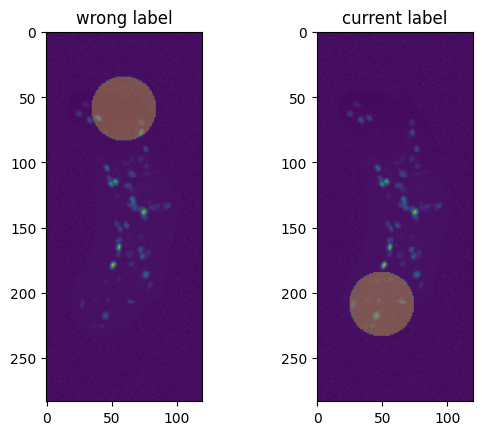

PyObject Text(0.5, 1.0, 'current label')

In [73]:
# manually correct the wrong labels in wrong_ones
let
    i = 342 # load in each of the wrong ones
    img_raw = cropped_images[i]
    wrong_lbl = cropped_labels[i]
    subplot(1,2,1)
    imshow(img_raw)
    imshow(wrong_lbl, alpha=0.3)
    title("wrong label")
    
    head_pt = [210, 50]
    img_label = zeros(Bool, size(img_raw))
    img_label[[x for x in CartesianIndices(size(img_label)) if euclidean_dist(Tuple(x),Tuple(head_pt)) < 25]] .= 1
    cropped_labels[i] = img_label
    subplot(1,2,2)
    imshow(cropped_images[i])
    imshow(cropped_labels[i], alpha=0.3)
    title("current label")
end

In [74]:
length(cropped_labels)

381

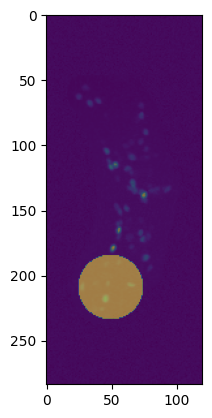

PyObject <matplotlib.image.AxesImage object at 0x720104580520>

In [80]:
### visualize corrected cropped img and label overlaid
i = 342 # 135,146, 256, 278, 342
cropped_img = cropped_images[i]
cropped_label = cropped_labels[i]

imshow(cropped_img)
imshow(cropped_label, alpha=0.5)

In [75]:
### Save output as another hdf5
path_new_h5 = "/store1/candy/prj_unet2d/data/immob_preCropNet_cropped.h5"
# path_new_h5 = "/store1/candy/prj_unet2d/data/preCropNet_cropped.h5"

h5open(path_new_h5, "w") do f
    for i in 1:length(cropped_labels)
        d = "$(i)"
        create_group(f, d)
        f[d]["img"] = UInt16.(cropped_images[i])
        f[d]["label"] = cropped_labels[i]
    end
end